In [1]:
import numpy as np, sys, os, holoviews as hv, scipy
sys.path.insert(0, '../') # add normal modules
from Utils import IO, plotting as plotz
import matplotlib.pyplot as plt

root = '../Data/new11'
data = IO.DataLoader(root)

settings = {k: IO.Settings(os.path.join(root, k)) for k in data}

import multiprocessing as mp
from multiprocessing.pool import ThreadPool
processes = mp.cpu_count()

aucs = loadedData = {}
for idx, (k, v) in enumerate(data.items()):
    tmp = os.path.join(root, k)
    setting = settings[k]
    
    tmp_worker = IO.Worker(v, settings[k])
    with ThreadPool(processes = processes) as p:
        p.map(tmp_worker, tmp_worker.idx)
        v = np.frombuffer(tmp_worker.buff, dtype = np.float64).reshape(*tmp_worker.buffshape)    
    del tmp_worker
    s = v.shape
    v = v.reshape(-1, setting.nNodes, setting.deltas // 2 - 1)
    v = np.array([(i - i.min()) / (i.max() - i.min()) for i in v])
    v = v.reshape(-1, s[-1])
    loadedData[k] = v.reshape(s)
    
#     if idx >= 10:
#         break
    
    




  0%|          | 0/21 [00:00<?, ?it/s]

Extracting data...
Done
Reading settings in ../Data/new11/2019-07-03T15:25:45.459318: using json
loading graph
Reading settings in ../Data/new11/2019-07-03T15:26:10.265725: using json
loading graph
Reading settings in ../Data/new11/2019-07-03T15:27:12.728531: using json
loading graph
Reading settings in ../Data/new11/2019-07-03T15:29:18.588943: using json
loading graph
Reading settings in ../Data/new11/2019-07-03T15:30:22.183082: using json
loading graph
Reading settings in ../Data/new11/2019-07-03T15:31:40.422819: using json
loading graph
Reading settings in ../Data/new11/2019-07-03T15:33:29.416130: using json
loading graph
Reading settings in ../Data/new11/2019-07-03T15:35:56.170227: using json
loading graph
Reading settings in ../Data/new11/2019-07-03T15:37:17.450392: using json
loading graph
Reading settings in ../Data/new11/2019-07-03T15:37:44.331217: using json
loading graph
Reading settings in ../Data/new11/2019-07-03T15:41:09.795595: using json
loading graph
Reading settings in

100%|██████████| 21/21 [00:01<00:00,  6.91it/s]


In [2]:
# a = next(iter(data))
# data[a]['0.8']['1']
# aucs = {}
# for k, v in loadedData.items():
#     aucs[k] = np.trapz(v.squeeze(), axis = -1)
#     print(aucs[k].shape)
# 
#     
# from Utils.misc import flattenDict
# 
# d = flattenDict(data)
# for i in d[:5]:
#     print(i)

In [3]:
def worker(sample):
    # tmp workaround
    if len(sample.shape) == 1:
        sample = sample.reshape(-1, 1)
    auc = np.zeros((len(sample), 2))
    coeffs, errors = plotz.fit(sample, func, params = fitParam)
    for nodei, c in enumerate(coeffs):
        tmp = 0
        F      = lambda x: func(x, *c) - c[0]
        tmp, _ = scipy.integrate.quad(F, 0, LIMIT)
        auc[nodei, 0] = tmp
        auc[nodei, 1] = errors[nodei]
        if errors[nodei] > .1:
            print('error large')
    auc[auc < np.finfo(auc.dtype).eps ] = 0
    return auc[:, 0]
from tqdm import tqdm

double = lambda x, a, b, c, d, e, f, g: a + b * np.exp(-c*(x - g)) + d * np.exp(- e * (x-f))

double_= lambda x, a, b, c, d, e, f: a +  b * np.exp(-c*(x)) + d * np.exp(- e * (x - f ))
single = lambda x, a, b, c : a + b * np.exp(-c * x)
single_= lambda x, a, b, c : a + b * np.exp(-c * x)
special= lambda x, a, b, c, d: a  + b * np.exp(- (x)**c - d)

func        = double
p0          = np.ones((func.__code__.co_argcount - 1)); # p0[0] = 0
fitParam    = dict(\
                   maxfev = int(1e6), \
                   bounds = (0, np.inf), p0 = p0,\
                   jac = 'cs'
                  )
aucs = {}
for k, v in tqdm(loadedData.items()):
    setting = settings[k]
    LIMIT = setting.deltas // 2 - 1
    LIMIT = np.inf
    s = v.shape
    v = v.reshape(-1, *s[-2:])
    with mp.Pool(mp.cpu_count()) as p:
        auc = np.asarray(p.map(worker, v)).reshape(s[:-1])
    aucs[k] = auc

100%|██████████| 30/30 [00:21<00:00,  1.45it/s]


# Notes on the data

Rick mentioned that it could be the case that although the data does not look linear, it is because each graph has some slightly odd behavior in regards of how the entropy decays. Meaning, it could be that across graphs the lines are not necessarily on a line. However, the prediction accuracy should still be high.

Things to check:
    - Check the ordering over time of the curves for different datasets
    - Check the prediction accuracy
    

In [4]:
from bokeh import plotting as bp
from bokeh.models import ColumnDataSource, CustomJS
import bokeh
bp.output_notebook()


tmp_aucs = [i.squeeze() for i in aucs.values()]
x = []

sets = [0, 2]

for i in tmp_aucs:
    idx = i[sets[1]].argmax()
#     tmp = i[sets].max(-1)
    tmp  = i[sets, idx]
#     print(i.shape)
    x.append(tmp)

tmp_aucs = np.asarray(x)
# print(tmp_aucs.shape, idx.shape); assert 0

tmp_mi   = [loadedData[i].squeeze() for i in aucs.keys()]
tmp_mi   = tmp_mi

viridis = bokeh.palettes.Viridis256
# setup data
buffer          = ColumnDataSource('x', 'y', \
                                   data = dict(x = [], \
                                               y = [], \
                                               color = [])\
                                  )

buffer_causal   = ColumnDataSource('x', 'y', \
                                   data = dict(x = [], \
                                               y = [],\
                                              color = []),\
                                  )

aucs_bokeh = ColumnDataSource('x', 'y', data = dict(x = tmp_aucs[:,0].tolist(), \
                                                    y = tmp_aucs[:, 1].tolist(), \
                                                    ),\
                              )

mi_bokeh    = ColumnDataSource(data = dict(y = [i[0].tolist() for i in tmp_mi]))
causal_bokeh= ColumnDataSource(data = dict(y = [i[sets[-1]].tolist() for i in tmp_mi]))

f1 = bp.figure(tools = 'hover tap lasso_select'.split(), width = 600)
f2 = bp.figure( height = int(f1.plot_height * .5 ))
f3 = bp.figure( height = int(f1.plot_height * .5 ))

for prop, label in zip('yaxis xaxis'.split(), ['Mutual information', 'time']):
    getattr(f2, prop).axis_label = label

for prop, label in zip('yaxis xaxis'.split(), ['Causal impact', 'time']):
    getattr(f3, prop).axis_label = label
f1.scatter('x', 'y', source = aucs_bokeh, size = 10)

# fi1.scatter()
f2.multi_line('x', 'y', source = buffer, color = 'color')
f3.multi_line(xs = 'x', ys = 'y', source = buffer_causal, color = 'color')

with open('dashboard.js', 'r') as f:
    callback = ''.join(i for i in f.readlines())
    
    JS =  CustomJS(\
             args = dict(buffer = buffer, \
                         mi     = mi_bokeh, \
                         buffer_causal = buffer_causal, \
                         causal = causal_bokeh, 
                         colors = bokeh.palettes.Magma256,\
              ),\
             code = callback)
aucs_bokeh.selected.js_on_change('indices', \
                                JS)
bp.show(bokeh.layouts.row(f1, bokeh.layouts.column(f2, f3)))


Loading BokehJS ...

# AUC for all data

showing the data for not only the driver-node

In [29]:
# aucs = {}
# for k, v in loadedData.items():
#     v = v.squeeze()
#     s = v.shape
#     v = v.reshape(v.shape[0], -1)
#     mi, ma = v.min(1), v.max(1)
#     print(v.shape)
#     mi = mi[:, None]
#     ma = ma[:, None]
# 
#     v = (v - mi) / (ma - mi)
#     print(v.max(1))
#     v = v.reshape(s)
#     aucs[k] = np.trapz(v, axis = -1)

predictions = np.zeros((len(loadedData), 2))

for idx, (k, v) in enumerate(aucs.items()):
    jdx = v.squeeze().argmax(-1)
    tmp = v.squeeze().argsort(-1)
    jdx = tmp[:, -1]
#     print(np.argsort(v.squeeze(), axis = -1)[:, -3:])
    tmp = jdx[0] == jdx[1:]
#     print(jdx, v.shape)
    predictions[idx] = tmp

fig = bp.figure()
colors = bokeh.palettes.Viridis256

N = len(colors) // len(aucs)
for idx,(k, v) in enumerate(aucs.items()):
    fig.scatter(*v.squeeze()[[0,2]], color = colors[idx * N])
#     print(v.squeeze()[[0,1]])
fig.xaxis.axis_label = 'Informational impact'
fig.yaxis.axis_label = 'Causal impact'
print(predictions.mean(0))
bp.show(fig)

[0.53333333 0.13333333]


(3, 10, 14)


<IPython.core.display.Javascript object>


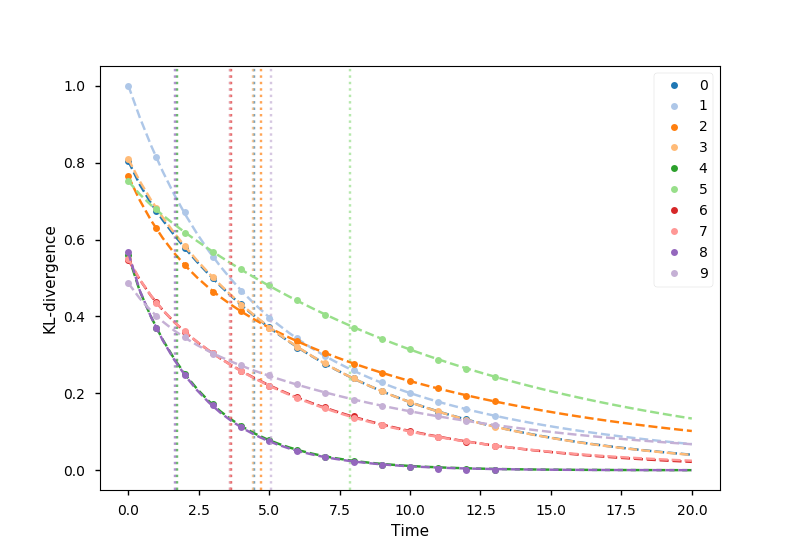

In [35]:
func = lambda x, a, b, c, d, e, f: a + b * np.exp(- c * x) + d * np.exp(- e * (x - f))
x = np.linspace(0, 20)
def idt(data, func, perc = .5, params = {}):
    """
    Compute idt for data set (node x time)
    """
    from Utils.plotting import fit
    coeffs, error = fit(data, func, params = params)
    idts = np.zeros((data.shape[0]))
    for idx, c in enumerate(coeffs):
        tmp = lambda x : abs(func(x, *c) - data[idx].max() * perc)
        idts[idx] = scipy.optimize.fmin(tmp, np.random.rand(), disp = 0)[0]
    return idts, coeffs
%matplotlib notebook
from matplotlib import style
style.use('seaborn-notebook')
params = dict(\
             maxfev = int(1e4),\
             bounds = (0, np.inf),\
             )
mi = next(iter(loadedData.values())).squeeze()
auc = next(iter(aucs.values())).squeeze()
print(mi.shape)
zdx = 2
idts, coeffs = idt(mi[zdx], func, .5, params)

fig, ax = plt.subplots()

colors = plt.cm.tab20(range(12))
for idx, vi in enumerate(mi[zdx]):
    ax.plot(vi, color = colors[idx], linestyle = 'none', marker=  '.', markersize = 10,\
           label = setting.rmapping[str(idx)])
    ax.axvline(idts[idx], color = colors[idx], alpha = .7, linestyle = ':', markersize = 1600)
    ax.plot(x, func(x, *coeffs[idx]), color = colors[idx], linestyle = 'dashed')
    
#     if idx == auc[zdx].argmax():
#         ax.add_artist(plt.Circle((20, 1) , color = colors[idx]))
ax.set(\
      xlabel = 'Time',\
      ylabel = 'KL-divergence' if zdx != 0 else 'Mutual information',\
      ) 

ax.legend()
fig.show()

[[0.07688201 0.0610484  0.05398068 0.04930272 0.04530313 0.04176108
  0.038592   0.03562611 0.03264699 0.03029274 0.0277765  0.02523671
  0.02327212 0.02137058]
 [0.1044972  0.08314952 0.06939345 0.06005191 0.05386637 0.04818292
  0.04320788 0.03853932 0.03467743 0.03140897 0.02837121 0.02525257
  0.02236345 0.02036888]
 [0.05226293 0.05147826 0.04993498 0.04801511 0.04597179 0.04332501
  0.04074089 0.03795363 0.03518375 0.0327541  0.03033096 0.02794419
  0.02581586 0.02389504]]
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
(3, 14)


<IPython.core.display.Javascript object>


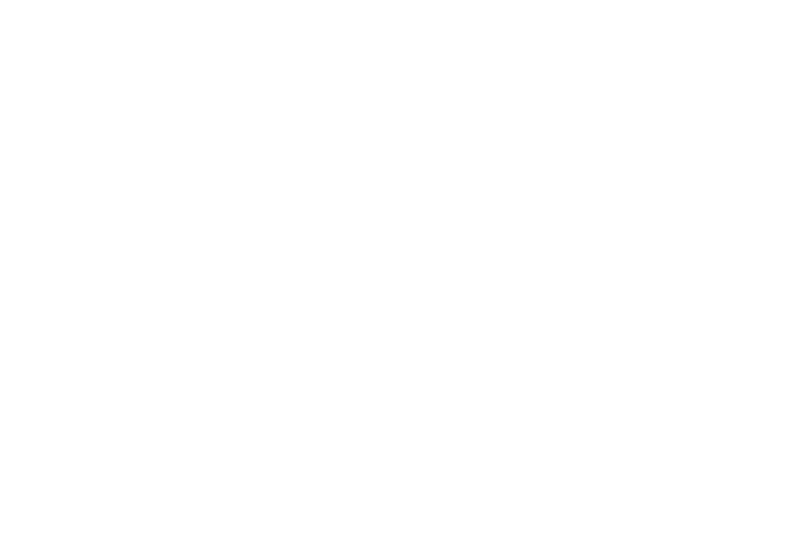

0 0.7391063271048008 0.6945689480723098
0 0.607649972280669 0.5732020319250783
0 0.5203361890325121 0.4909808404917055
0 0.46242563450474106 0.4279972536413542
0 0.41816567271768723 0.3766986613278576
0 0.3756230029281689 0.33466107708572
0 0.3433605839262377 0.29863374022466127
0 0.3086199617889673 0.2660163691647253
0 0.2845191101503379 0.24027889743113934
0 0.2581834103440349 0.21578493991839126
0 0.23262533485995132 0.19294054793871956
0 0.21242915973012472 0.1746825956965602
0 0.19248886920079705 0.15793339728496086
1 0.8149365550326113 0.7640949957771715
1 0.6700010990454041 0.6247472900638952
1 0.5669666046068067 0.5231357524550055
1 0.4861355298212998 0.45184214442133774
1 0.4168704188723259 0.3940266695950567
1 0.36760812955249095 0.3447531238735131
1 0.33153449093895593 0.30244444311206176
1 0.30602643928064444 0.26625751663590436
1 0.28631031009020913 0.2385685708242265
1 0.26029882033375745 0.21269146905836278
1 0.23265570057338075 0.18714850898771104
1 0.20913829805811712 

In [7]:
mu = mi.mean(1)
# var = mi.std(1)

from scipy.stats import sem
var = sem(mi, axis = 1)
print(var)
setting = next(iter(settings.values()))
print(setting.mapping)
print(mu.shape)

theta = 4
times = np.zeros((3), dtype = int)

fig, ax = plt.subplots()
for idx, i in enumerate(mi):
    for jdx, j in enumerate(i.T):
        dd = np.argsort(j)
        second, first = dd[-2:]
        ax.scatter(jdx,  (j[first] - j[second])**2, color = colors[idx])
        if jdx > 0:
            print(idx, j[first], mu[idx, jdx] + theta * var[idx, jdx])
            
            if j[first] > mu[idx, jdx] + theta * var[idx, jdx]:
                times[idx] = jdx
            else:
                break
            
print(times)
print(setting.rmapping)
for idx, i in enumerate(times):
    node = mi[idx, :, i].argmax()
    print(idx, setting.rmapping[str(node)])
print(times)

In [25]:
# tmp_aucs = np.asarray([i for i in aucs.values()]).squeeze()

# tmp_aucs = np.sort(tmp_aucs, axis = -1)[..., -1:]

# print(tmp_aucs.shape)
# fig, ax = plt.subplots()
# colors = plt.cm.Spectral(np.linspace(0, 1, len(tmp_aucs)))
# [ax.scatter(*i[:2], color = colors[idx]) for idx, i in enumerate(tmp_aucs)]
# fig.show()

idx = []
for k, v in aucs.items():
    # get max
    tmp = np.argsort(v.squeeze(), axis = -1)
    if tmp[0, -1] != tmp[1, -1]:
        idx.append(k)


14

-------------------------------- Simulation Settings --------------------------------
directory       = /var/scratch/cveltere/2019-07-03T15:26:10.259201//2019-07-03T15:41:58.699504
repeats         = 10000
deltas          = 30
nSamples        = 50000
step            = 1000
burninSamples   = 0
nNodes          = 10
nTrials         = 1
pulseSizes      = [0.5, inf]
nudgeType       = constant
updateType      = 0.25
model           = Ising
--------------------------------------------------------------------------------------
(2, 10, 14)


<IPython.core.display.Javascript object>


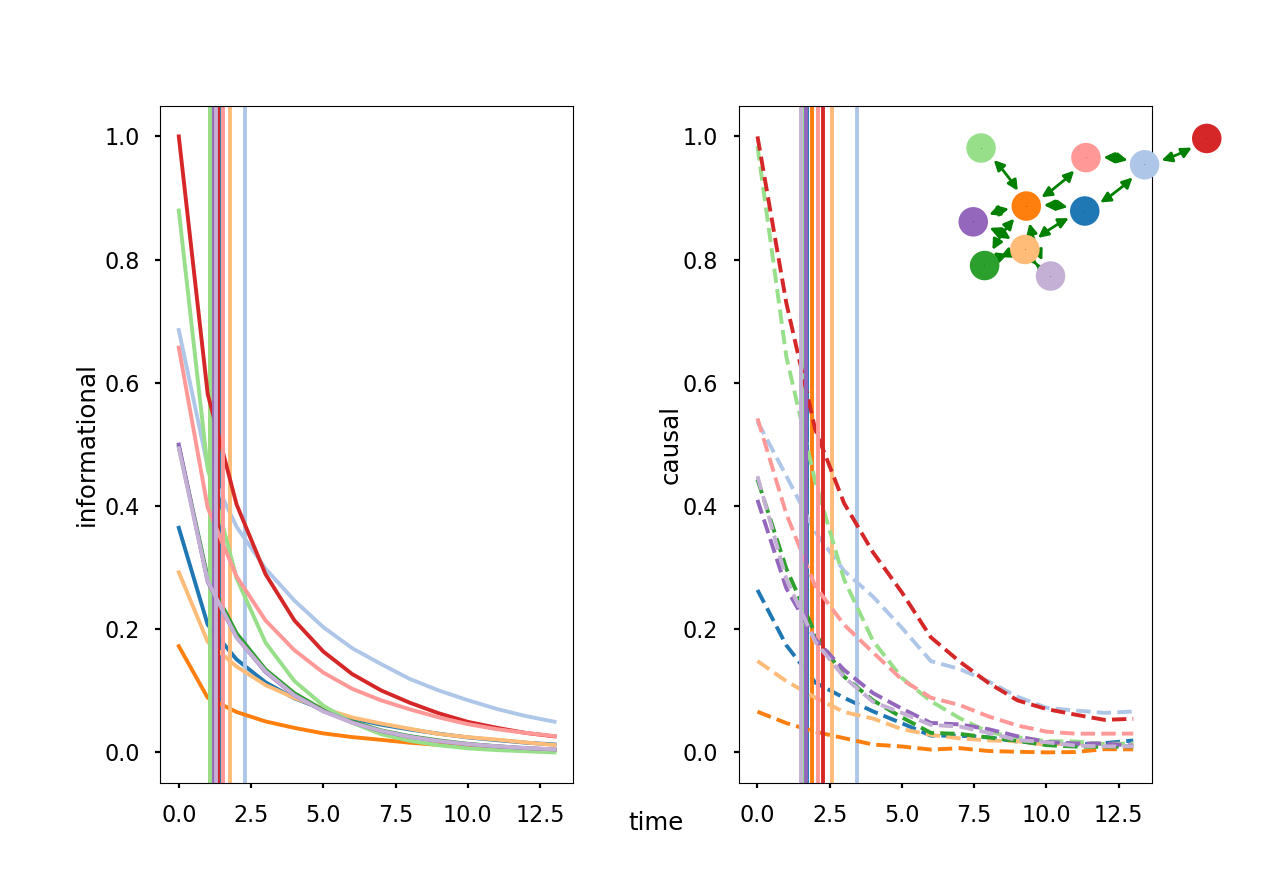

User provided position function
[[2 0 3 9 8 4 5 7 6 1]
 [2 3 0 4 8 9 7 5 1 6]
 [5 6 9 8 4 7 0 1 3 2]]

-------------------------------- Simulation Settings --------------------------------
directory       = /var/scratch/cveltere/2019-07-03T15:26:10.259201//2019-07-03T15:41:58.699504
repeats         = 10000
deltas          = 30
nSamples        = 50000
step            = 1000
burninSamples   = 0
nNodes          = 10
nTrials         = 1
pulseSizes      = [0.5, inf]
nudgeType       = constant
updateType      = 0.25
model           = Ising
--------------------------------------------------------------------------------------


In [27]:
tmp = idx[5]
print(len(idx))
def idt(data, perc = .5, params = {}):
    """
    Compute idt for data set (node x time)
    """
    from Utils.plotting import fit
    
    func = lambda x, a, b, c, d, e, f: a + b * np.exp(- c * x) + d * np.exp(- e * (x - f))
    coeffs, error = fit(data, func, params = params)
    idts = np.zeros((data.shape[0]))
    for idx, c in enumerate(coeffs):
        tmp = lambda x : abs(func(x, *c) - data[idx].max() * perc)
        idts[idx] = scipy.optimize.fmin(tmp, np.random.rand(), \
                                       disp = 0)[0]
    return idts


print(settings[tmp])
        
import matplotlib.pyplot as plt
d = loadedData[tmp][:2].squeeze()

idts = idt(d[1], params = dict(bounds = (0, np.inf), maxfev = int(1e4)))
idts2= idt(d[0], params = dict(bounds = (0, np.inf), maxfev = int(1e4)))
print(d.shape)
colors = plt.cm.tab20(range(d.shape[1]))
fig, (ax, tax) = plt.subplots(1, 2)
for node in range(d.shape[1]):
    ax.plot(d[0, node], color = colors[node])
    ax.axvline(idts2[node], color = colors[node])
    tax.plot(d[1, node], color = colors[node], linestyle = 'dashed')
    tax.axvline(idts[[node]], color = colors[node])
tax.set(ylabel = 'causal')
tax.yaxis.labelpad = 0
ax.set(ylabel = 'informational')

# elements = [plt.Line2D([0], [0], linestyle = i, color = 'k', label = j) for i, j in zip(\
#                    'dashed solid'.split(), 'causal informational'.split())]
# ax.legend(handles = elements)
mainax = fig.add_subplot(111, xticks = [] , yticks = [], frameon = False)
mainax.set_xlabel('time', labelpad = 20)

inax = tax.inset_axes([0.5, 0.5, 0.7, 0.7])
import networkx as nx
graph = nx.node_link_graph(settings[tmp].graph)
from Utils.plotting import addGraphPretty
addGraphPretty(graph, positions = nx.spring_layout, ax = inax, colors = colors)
inax.axis('off')
fig.subplots_adjust(wspace = .4)
print(np.argsort(aucs[tmp], axis = -1).squeeze())
print(settings[tmp])
    

In [10]:
from Models import fastIsing
match = .8
m = fastIsing.Ising(graph = graph, \
                    updateType = '0.25', \
                    magSide = 'neg', \
                    nudgeType = 'constant',\
                    nudges = {})
#m = potts.Potts(graph = g, agentStates = [1, 2])

temps = np.logspace(-3, np.log10(graph.number_of_nodes()), 50)
temps = np.linspace(0, 10, 50)
samps = [m.matchMagnetization(temps, 100) for i in range(10)]

  0%|          | 0/50 [00:00<?, ?it/s]

Computing mag per t


  2%|▏         | 1/50 [00:00<00:06,  7.79it/s]

Computing mag per t


  2%|▏         | 1/50 [00:00<00:08,  5.52it/s]

Computing mag per t


 10%|█         | 5/50 [00:00<00:03, 12.27it/s]

Computing mag per t


  2%|▏         | 1/50 [00:00<00:08,  5.58it/s]

Computing mag per t


  2%|▏         | 1/50 [00:00<00:07,  6.64it/s]

Computing mag per t


  0%|          | 0/50 [00:00<?, ?it/s]

Computing mag per t


  4%|▍         | 2/50 [00:00<00:07,  6.57it/s]

Computing mag per t


  2%|▏         | 1/50 [00:00<00:07,  6.94it/s]

Computing mag per t


  0%|          | 0/50 [00:00<?, ?it/s]

Computing mag per t


100%|██████████| 50/50 [00:01<00:00, 29.41it/s]


Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 18
         Function evaluations: 36


<IPython.core.display.Javascript object>


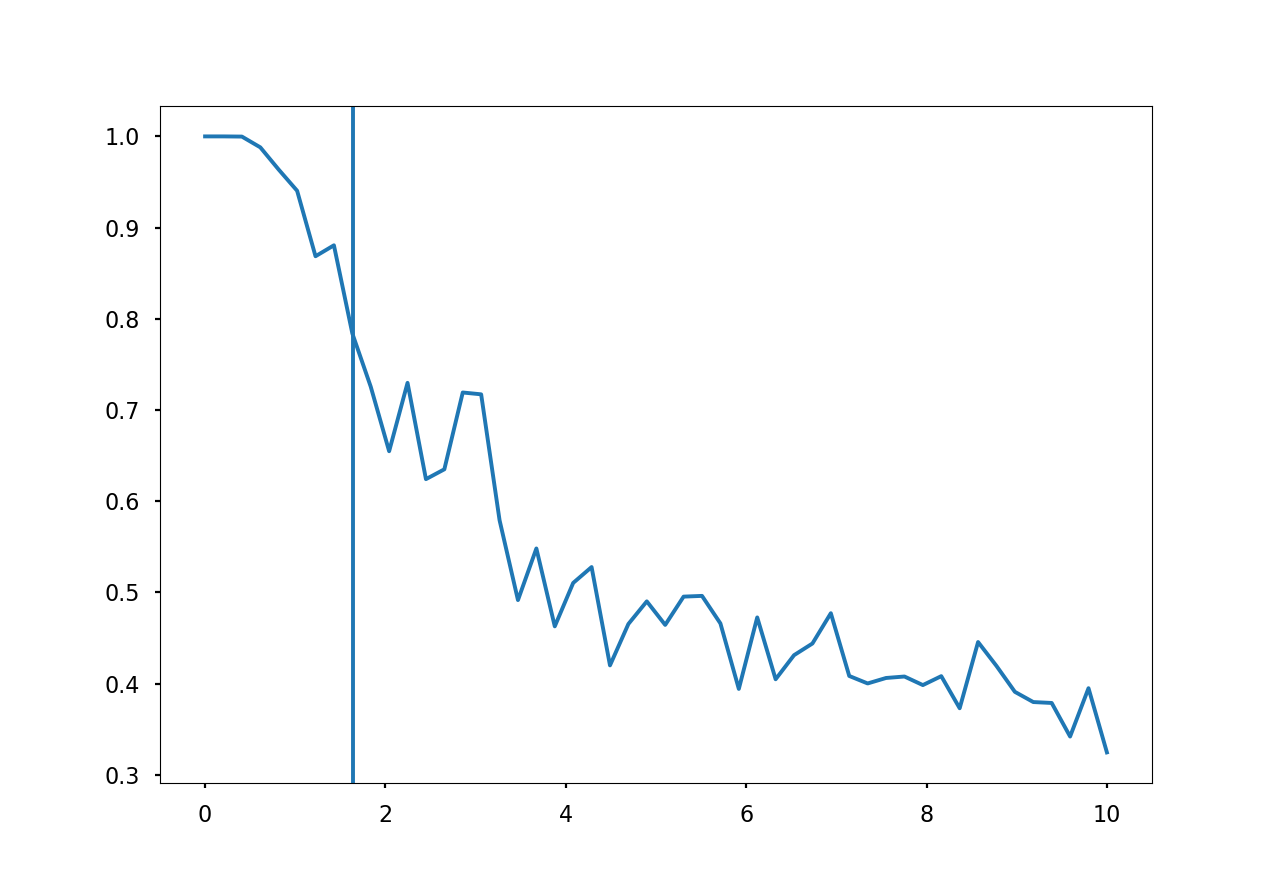

In [22]:
tsamps = np.asarray(samps).mean(0)
mag, sus = tsamps
import scipy
sig = lambda x, a, b, c, d:  c / (1 + np.exp(a *(x - b))) + d
coeffs, _ = scipy.optimize.curve_fit(sig, temps, mag, maxfev = 10000)
x0 = scipy.optimize.fmin(lambda x : abs(sig(x, *coeffs) - match* mag.max()), .5)[0]

fig, ax = plt.subplots()
ax.plot(temps, tsamps[0])
ax.axvline(x0)
fig.show()
m.t = x0

In [19]:
from Toolbox import infcy
from Utils import stats
nudges = np.logspace(-2, 0, 5)

snapshots    = infcy.getSnapShots(m, nSamples = int(1e4), steps = int(1e3),  nThreads = -1)
deltas       = 50
repeats      = int(1e4)
conditional, px, mi = infcy.runMC(m, snapshots, deltas, repeats)
nudgedData = np.zeros((nudges.size, m.nNodes, deltas))
for nidx, nudge in enumerate(nudges):
    for node, idx in m.mapping.items():
        m.nudges = {node : nudge}
        c, p, n = infcy.runMC(m, snapshots, deltas, repeats)
        nudgedData[nidx, idx] = stats.KL(px, p).sum(-1)
        
        

  0%|          | 0/386 [00:00<?, ?it/s]

done
Found 386 states
Delta =  2.40 sec
Decoding..
starting runs


100%|██████████| 386/386 [00:34<00:00, 11.19it/s]
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.53 sec
Decoding..
starting runs


100%|██████████| 386/386 [00:36<00:00,  6.47it/s]
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  36.16 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  40.63 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.87 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  37.98 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  40.04 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.61 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.93 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.43 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  37.53 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  37.17 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  39.78 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  37.47 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  43.15 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  36.38 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.17 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.26 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.43 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.15 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.85 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  35.49 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  35.70 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.48 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.67 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.94 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.94 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.47 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.62 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  35.82 sec
Decoding..
starting runs


100%|██████████| 386/386 [00:00<00:00, 569870.24it/s]


Delta =  44.79 sec
Decoding..


  0%|          | 0/386 [00:00<?, ?it/s]

starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  42.59 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  40.34 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.76 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.53 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.15 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  35.26 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  45.58 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.25 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  36.13 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  37.91 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  38.16 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.24 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.80 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.05 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.92 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.39 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.90 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  34.73 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.81 sec
Decoding..
starting runs


  0%|          | 0/386 [00:00<?, ?it/s]

Delta =  33.52 sec
Decoding..
starting runs


100%|██████████| 386/386 [00:33<00:00, 11.43it/s]

Delta =  33.79 sec


<IPython.core.display.Javascript object>


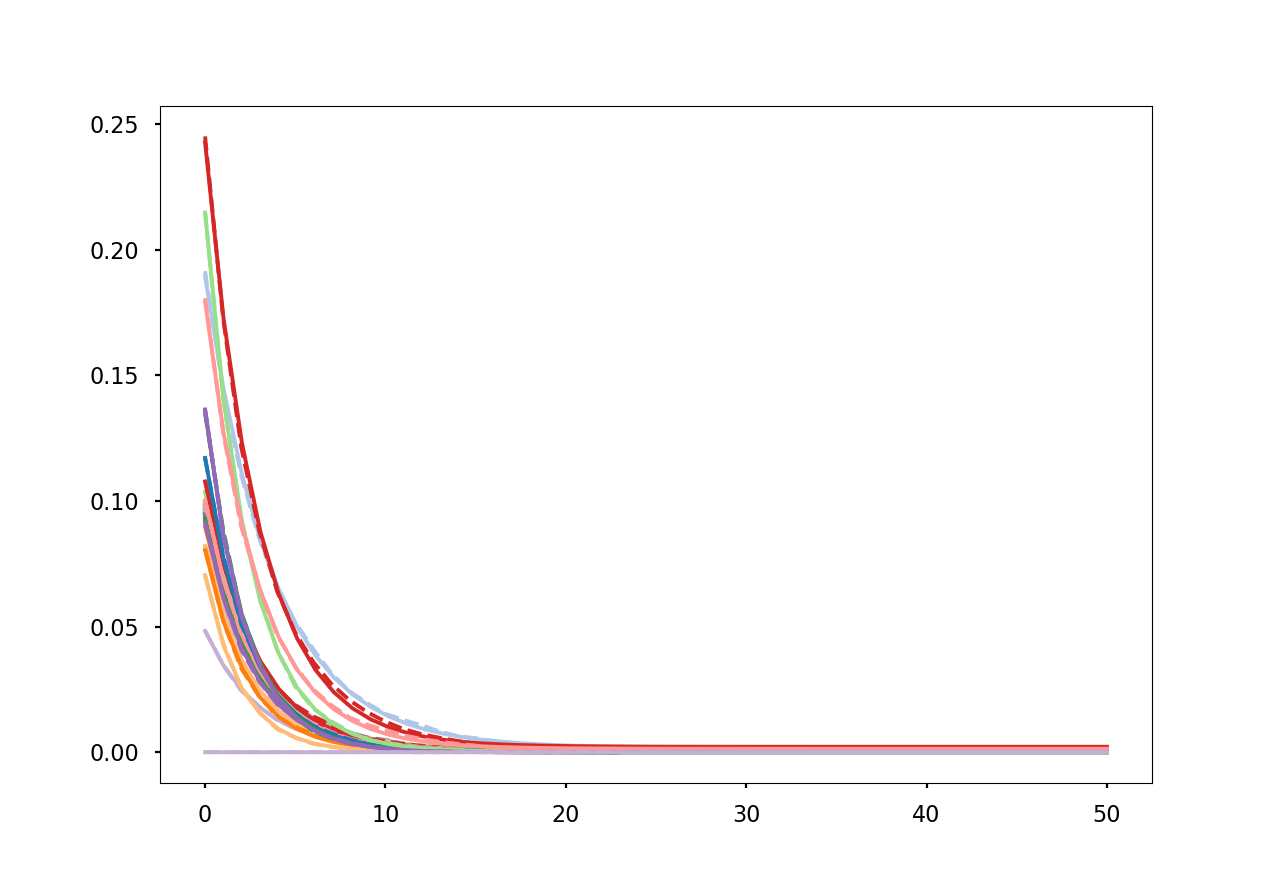

<IPython.core.display.Javascript object>


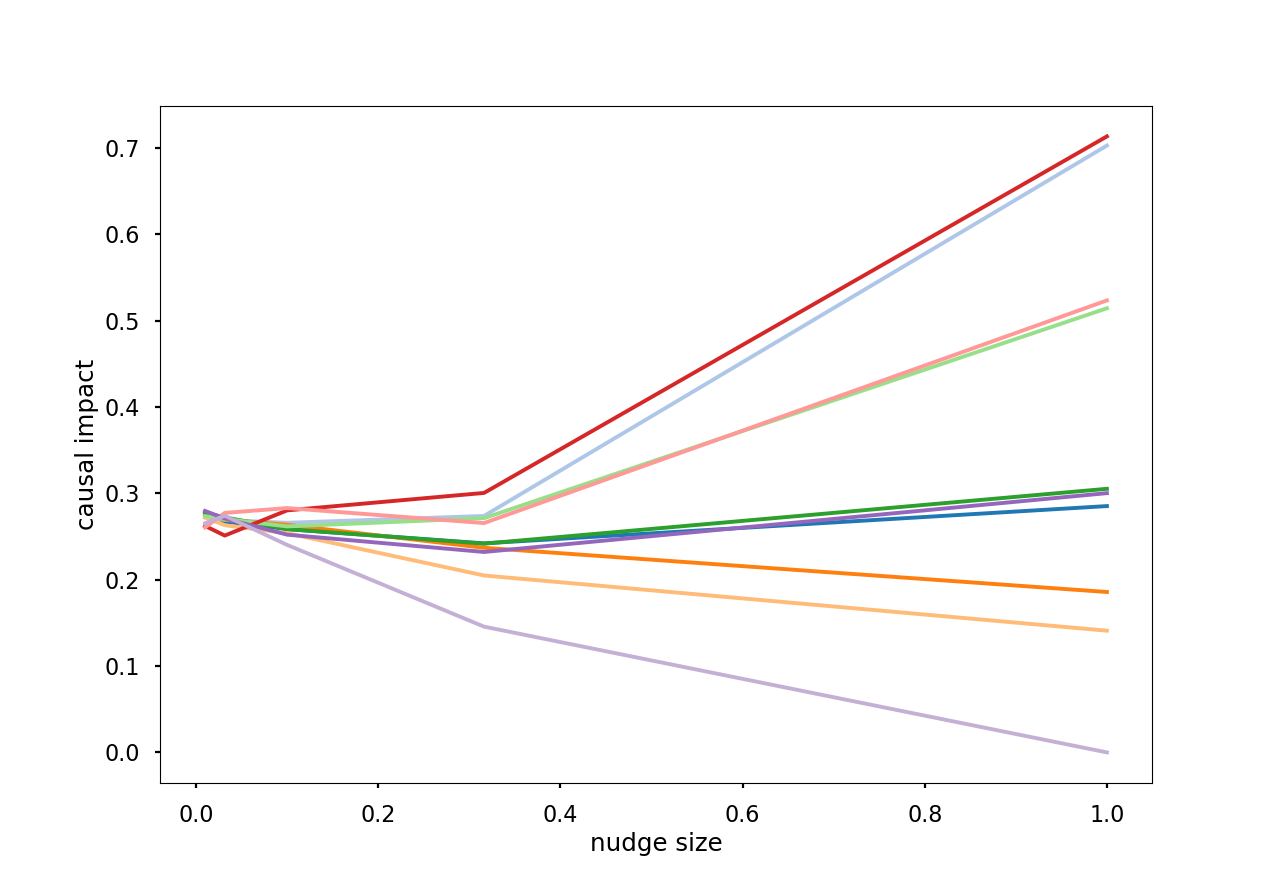

<IPython.core.display.Javascript object>


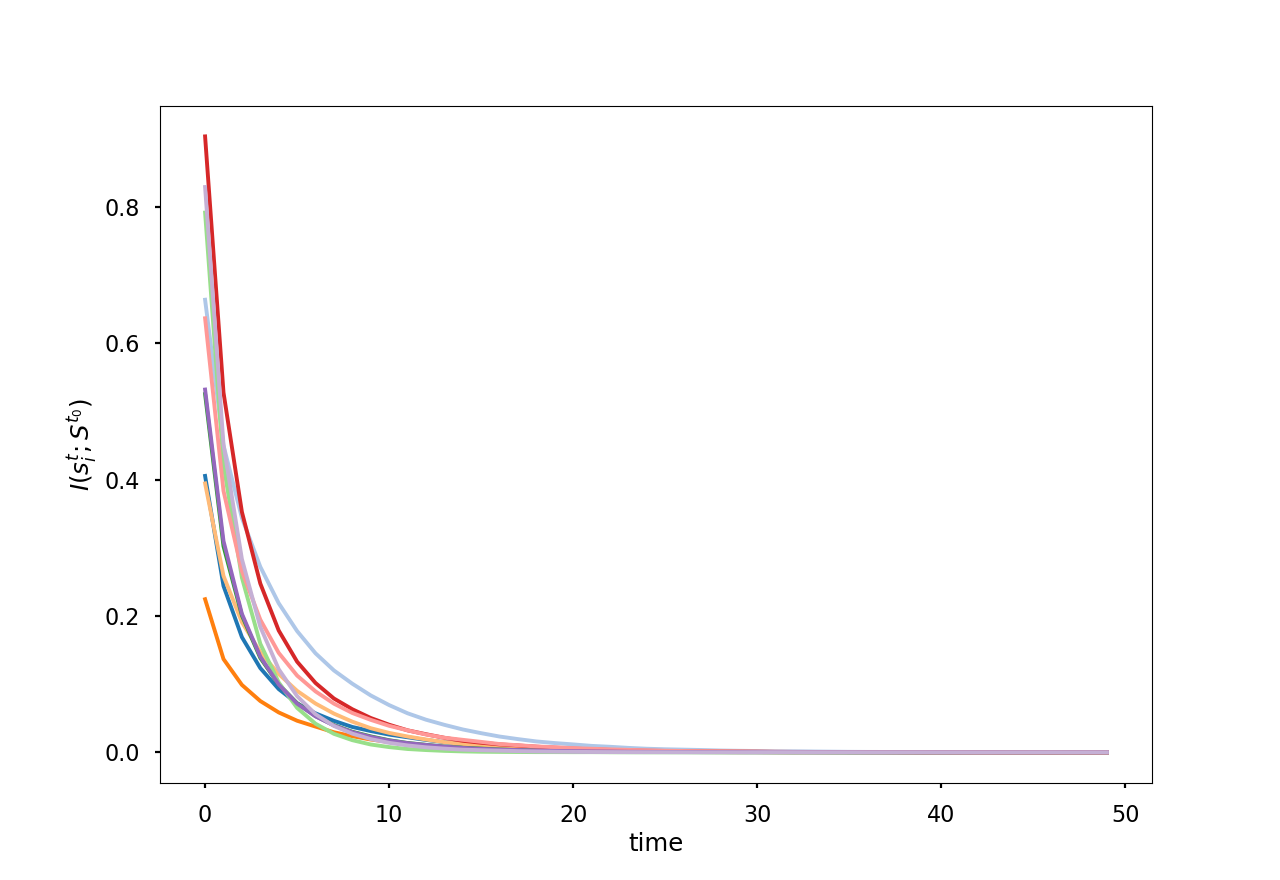

In [20]:
from Utils.plotting import fit
params = dict(\
             bounds = (0, np.inf),\
             jac = 'cs', maxfev = 100000)

func = lambda x, a, b, c, d, e, f, g: a + b * np.exp(- c * (x - d)) + e * np.exp(-f * g)
# extact the area under the curve
tmp = nudgedData[..., deltas // 2 + 1:]
h = np.zeros(nudgedData.shape[:-1])

fig, ax = plt.subplots()
xx = np.linspace(0, deltas)
for nidx in range(nudgedData.shape[0]):
    coeffs, err = fit(tmp[nidx], func, params = params)
    
    for idx, c in enumerate(coeffs):
        ax.plot(xx, func(xx, *c), color = colors[idx])
        
        ax.plot(tmp[nidx, idx], color = colors[idx], linestyle = 'dashed')
        h[nidx, idx] = scipy.integrate.quad(lambda x: func(x, *c) - c[0], 0, np.inf)[0]

        
# plot auc for the nudge per nudge size
fig, ax = plt.subplots()
for k, v in m.mapping.items():
    ax.plot(nudges, h[:, v], color = colors[v])
ax.set(yscale = 'linear')
ax.set(ylabel = 'causal impact', xlabel = 'nudge size')
fig.show()

# plot the mi curves
fig, ax = plt.subplots()
for k,v in m.mapping.items():
    ax.plot(mi[:, v], color = colors[v])
ax.set(xlabel = 'time', ylabel = '$I(s_i^t ; S^{t_0})$')
fig.show()

<IPython.core.display.Javascript object>


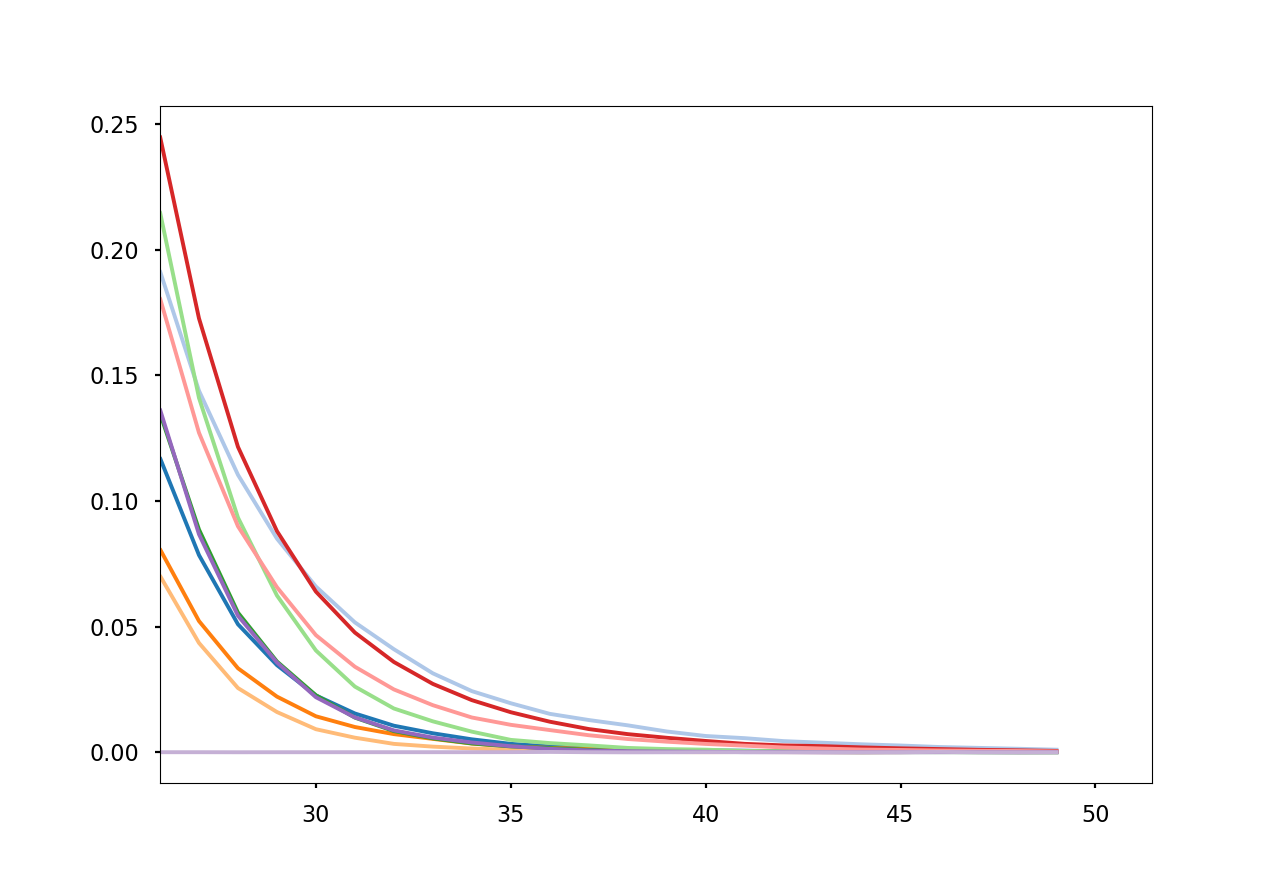

In [23]:
jdx = 4 
fig, ax = plt.subplots()
for k, v in m.mapping.items():
    ax.plot(nudgedData[jdx, v], color = colors[v])
ax.set_xlim(deltas // 2 + 1 )
fig.show()

<IPython.core.display.Javascript object>


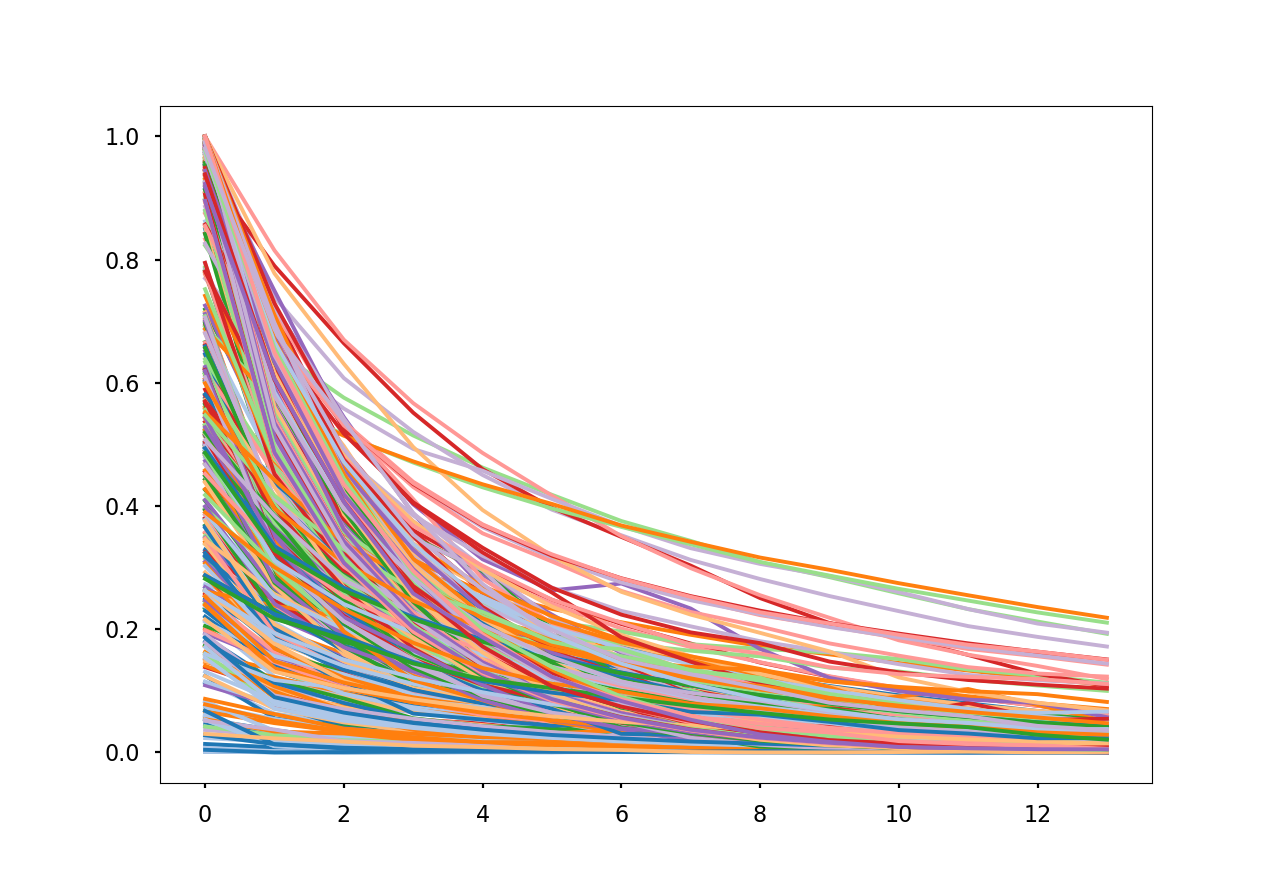

In [21]:
fig, ax = plt.subplots()
colors = plt.cm.tab20(range(12))
for k, v in loadedData.items():
    for i in v.squeeze()[:2]:
        for idx, j in enumerate(i):
            ax.plot(j, color = colors[idx])
        
fig.show()

<IPython.core.display.Javascript object>


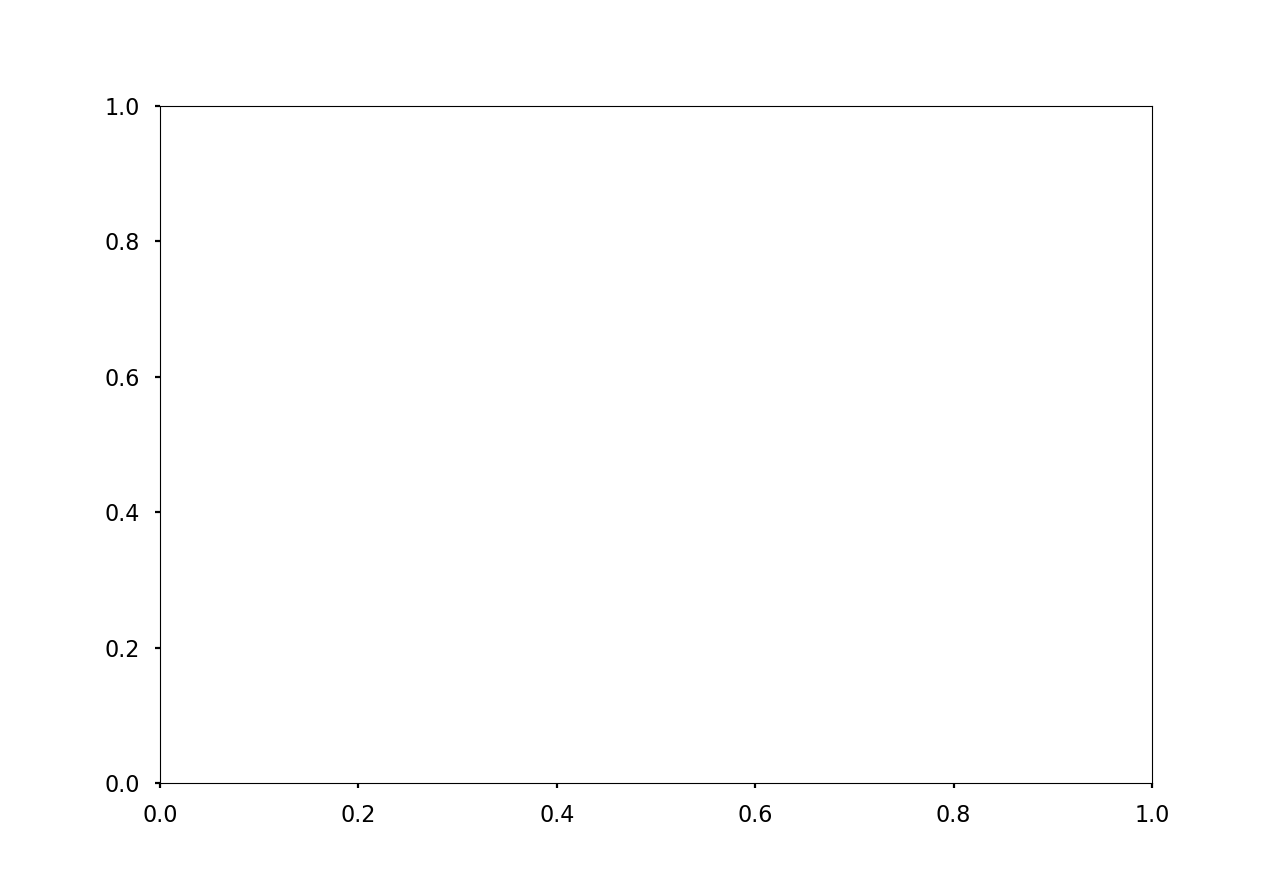

IndexError: index 9 is out of bounds for axis 1 with size 1

In [17]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('seaborn-poster')
fig, ax = plt.subplots()
sets = [0, 1]
for k, v in aucs.items():
    idx = v[sets[-1]].argmax()
    ax.scatter(*v[sets, idx], marker = '.')
    ax.scatter(*v[sets, :].max(1), marker = '.')
    ax.set(xlabel = 'informational impact', ylabel = 'causal impact')
    
fig.show()

In [ ]:
# make confusion matrices
from sklearn.metrics import confusion_matrix

tmp = np.zeros((len(aucs), 2))
for idx, (k, v) in enumerate(aucs.items()):
    jdx = np.argmax(v, axis = -1)
    tmp[idx] = jdx[0] == jdx[1:]
print(tmp.mean(0))


In [ ]:
params = dict(bounds = (0, np.inf), maxfev = int(1e4))
from tqdm import tqdm_notebook as tqdm


idts = np.zeros((70, 3, 10))
for z, (k, v) in enumerate(tqdm(loadedData.items())):
    v = v.squeeze() # remove stranglers
    
    for idx, vi in enumerate(v):
        tmp = idt(vi, params = params)
        idts[z, idx] = tmp


    

In [ ]:
fig, ax = plt.subplots()
sets = [0, 1]
print(idts.shape)
tmp = idts

hh = np.zeros((len(tmp), 2))
for jdx, i in enumerate(tmp):
    j = np.argmax(i, axis = -1)
    hh[jdx] = j[0] == j[1:] 
#     print(i.argmax(-1))
    ax.scatter(*i[[0, 1]])
#     ax.scatter(*i[[0, 2]])
ax.set(xlabel = 'Informational half-time', ylabel = 'Causal half-time')
ax.set_title('High causal' if sets[-1] == 2 else 'Low causal')
fig.show()
print(hh.mean(0))

fig, ax = plt.subplots()
ax.imshow(hh, aspect=  'auto')
fig.show()

fig, ax = plt.subplots(); ax.imshow(idts[0], aspect = 'auto')
fig.show()

In [ ]:
from matplotlib import style
import matplotlib.pyplot as plt
style.reload_library()
%matplotlib inline
style.use('seaborn-poster')
fig, ax = plt.subplots(3,1, sharex = 'all')
labels = '0.5 1 inf'.split()
print(len(aucs))
for k, v in aucs.items():
    tmp = v.squeeze()
    jdx = np.argsort(tmp, axis = -1)[:, -1]
#     print([tmp[i, j] for i, j in enumerate(jdx)])
    for idx, axi in enumerate(ax):
        y = tmp[[0, idx + 1]]
        axi.scatter(*y[:, jdx[idx + 1]], color = 'blue', alpha = .2)
#         axi.scatter(*tmp[[0, idx + 1]].max(-1), color = 'red', alpha = .2)
        axi.set_title(labels[idx])
    
mainax = fig.add_subplot(111, frameon = 0, xticks = [], yticks = [])
mainax.set(xlabel = 'Informational impact', ylabel = 'Causal impact')

fig.subplots_adjust(wspace = .3)

axi.legend(handles = [plt.Line2D([0], [0], color = i, label = j) for i, j in zip(\
                    'blue red'.split(), 'matched max'.split())], bbox_to_anchor = (1.15, 1))
fig.show()

In [ ]:
import networkx as nx
perc = np.zeros((len(aucs), 2))

# fig, ax = plt.subplots(3, 1, figsize = (10, 16))
colors = plt.cm.gist_ncar(np.linspace(0, 1, len(aucs)))

labels = "Informational impact\tUnderwhelming causal".split('\t')
for idx, (k, v) in enumerate(aucs.items()):
    
    tmp = np.argsort(v.squeeze(), axis = -1)[:, -1]
    perc[idx] = tmp[[0]] == tmp[[1, 2]]
    if not perc[idx, 0]:
        d = loadedData[k].squeeze()
        gs = dict(\
                 width_ratios = [1, 1, 1]\
                 )
        fig, ax = plt.subplots(1,3, gridspec_kw = gs)
        
        mainax = fig.add_subplot(111, \
                 frameon = 0, xticks = [], yticks = [])
        mainax.set_title(k, pad = 25)
        colors = plt.cm.Spectral(np.linspace(0, 1, settings[k].nNodes))
        g = settings[k].graph
        g = nx.node_link_graph(g)
        pos    = nx.circular_layout(g)
        subset = np.argsort(v.squeeze(), -1)[:, -2:]
        print(subset)
        for kk, axi in enumerate(ax[:2]):
            sub = subset[kk]
            [axi.plot(i, color = c, alpha = .4) for i, c in zip(d[kk, sub], colors[sub])]
            axi.set_title(labels[kk])
        nx.draw_networkx_nodes(g, pos = pos, node_color = colors, ax = ax[-1])
        nx.draw_networkx_edges(g, pos = pos, ax = ax[-1])
        ax[-1].set_aspect('equal', 'box')
        ax[-1].axes.axis('off')
        
            
        
#     vv = loadedData[k]
#     for jdx, label in enumerate(tmp):
#         axi = ax[jdx]
#         d = loadedData[k].squeeze()
#         print(d.shape)
#         axi.scatter(*d[[0, jdx + 1], label, :])
#         axi.plot(vv.squeeze()[jdx, label, :])
        
    
print(perc.mean(0), perc.std(0))


In [ ]:
fig, ax = plt.subplots()
for k, v in aucs.items():
    ax.scatter(*v[[0,1]].squeeze())
fig.savefig('test.png')

import networkx as nx
nx.from_pan
nx.from_edgelist([[0,1], [1,0]])